# Imports

In [1]:
import textblob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from IPython.display import display_html
from tqdm import tqdm,tqdm_pandas

# Analise dos dados

Faremos primeiramente uma breve análise dos dados do dataset de treino. Trata-se de um dataset com 1503424 registros e 18 colunas, com seus respectivos tipos descritos abaixo.

In [2]:
# Leitura dos dados do dataset
data = pd.read_csv('file/train-full.csv', encoding='utf8',  parse_dates=["activation_date"])    

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null datetime64[ns]
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: datetim

## Eliminando colunas desnecessárias

Optamos por eliminar algumas colunas que certamente não influenciam a probabilidade de sucesso de um anúncio, como identificadores e números sequenciais gerados automaticamente pela plataforma. Podemos então verificar como esses dados estão dispostos, utilizando uma função do Pandas que permite exibir as primeiras linhas de um DataFrame.

In [3]:
columns_to_drop =['item_id','item_seq_number']
data.drop(columns=columns_to_drop, inplace=True)
data.head(5)

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,activation_date,user_type,image,image_top_1,deal_probability
0,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


## Período de geração dos dados

O dataset registra anúncios criados de 15 de março de 2017 até 7 de abril do mesmo ano, como mostrado no gráfico abaixo. Observa-se que o dia da ativação do anúncio não teve grande impacto sobre a probabilidade de efetivação da venda durante o mês de março, porém nota-se um aumento dessa probabilidade, em média, durante o mês de abril.

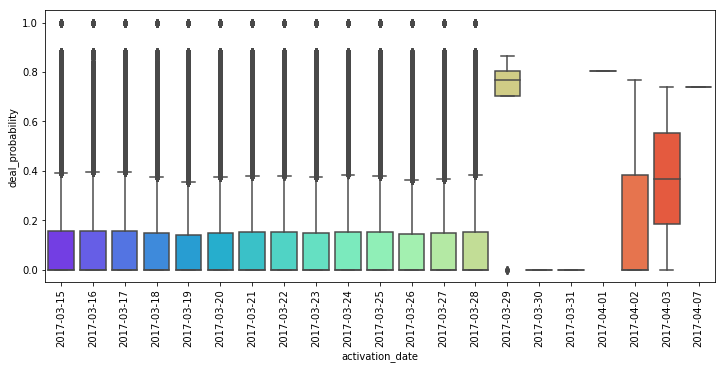

In [4]:
plt.figure(figsize=(12,5))
plt.xticks(rotation='vertical')
sns.boxplot(x=data.sort_values('activation_date')['activation_date'].dt.date, y='deal_probability', data= data, palette='rainbow')
plt.show()

# Colunas Númericas

Pela análise dos gráficos, podemos observar que não há uma correlação entre a probabilidade de efetivação do negócio e o preço anunciado, e há uma baixa correlação dessa probabilidade com a propriedade 'image_top_1'.  

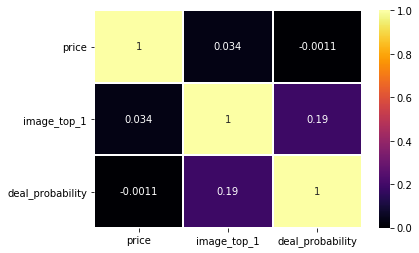

In [8]:
corr = data.corr()
sns.heatmap(corr, cmap = 'inferno', annot=True,linewidths=1)
plt.show()

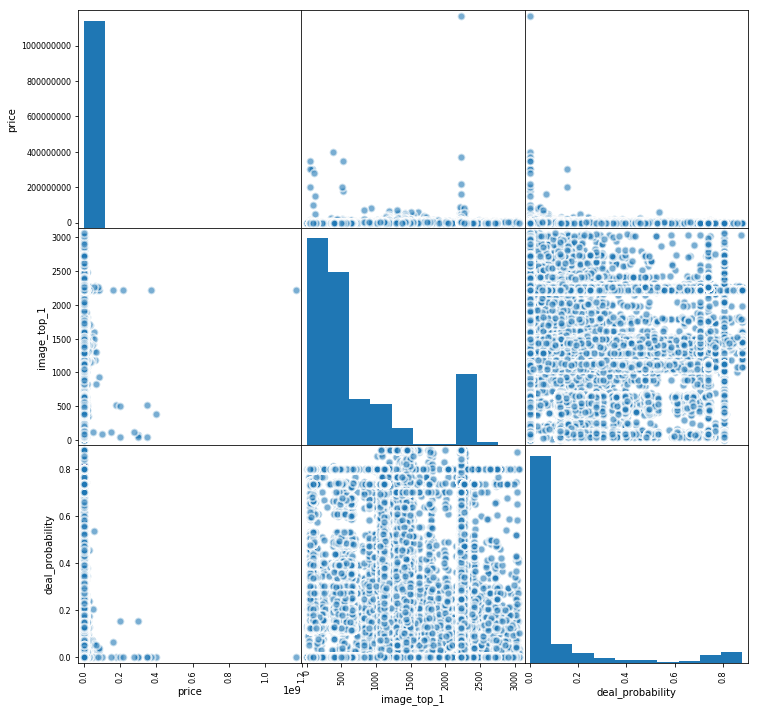

In [9]:
scatter_matrix(data.dropna(), alpha=0.6, figsize=(12,12), marker='o', s=60,linewidths=2, edgecolor='w')
plt.show()

Mostra-se os dados estatísticos descritivos dessas colunas. Nota-se que a probabilidade de venda do anúncio é, em média, abaixo de 15%, onde pelo menos 50% dos anúncios desse dataset têm esta probabilidade igualada a 0. Pela análise dos quartis, podemos notar que a média da coluna preço está muito alta em relação ao totalidade dos dados, havendo a presença de um ou mais outliers, como o de valor máximo 79501011850.00

,price,image_top_1,deal_probability
count,1418062.00,1390836.00,1503424.00
mean,316708.09,1241.93,0.14
std,66891542.10,970.46,0.26
min,0.00,0.00,0.00
25%,500.00,425.00,0.00
50%,1300.00,1057.00,0.00
75%,7000.00,2217.00,0.15
max,79501011850.00,3066.00,1.00


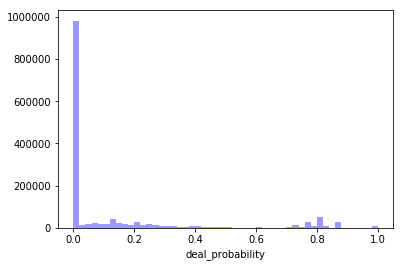

In [11]:
pd.options.display.float_format = "{:.2f}".format
display(data.describe())
sns.distplot(data.deal_probability.values, kde = False, axlabel = 'deal_probability', color='blue')
plt.show()

## Traduzindo Colunas Categóricas

Nota-se que os dados do dataset são todos em russo, uma linguagem que nós desconhecemos, o que dificultaria uma análise mais transparente nessa etapa do trabalho. Portanto, decidimos, para esta etapa, traduzir os dados das colunas categóricas para o inglês, utilizando a bilioteca de processamento de texto TextBlob.

In [12]:
def translate(x):
    try:
        return ''.join(textblob.TextBlob(x).translate(to="en"))
    except:
        return x

columns_to_translate = ["region","city","parent_category_name","category_name","param_1","param_2","param_3"]
    
for column in columns_to_translate:
    print("Traduzindo coluna " + column + ":")
    columnGroups = pd.Series(list(data.groupby(column).groups))
    tqdm.pandas(tqdm())
    columnGroupsEN=columnGroups.progress_map(translate)
    dictionaryGroupsTranslate = dict(zip(list(columnGroups), list(columnGroupsEN)))
    data[column] = pd.Series(list(str(dictionaryGroupsTranslate.get(word, word)) for word in data[column]))


0it [00:00, ?it/s]

Traduzindo coluna region:



100%|██████████| 28/28 [00:05<00:00,  7.09it/s]

0it [00:00, ?it/s]

  0%|          | 0/1733 [00:00<?, ?it/s]

Traduzindo coluna city:



 18%|█▊        | 305/1733 [00:43<03:29,  6.83it/s]


 35%|███▌      | 607/1733 [01:28<02:33,  7.33it/s]


 52%|█████▏    | 909/1733 [02:13<01:58,  6.96it/s]


 70%|██████▉   | 1207/1733 [02:57<01:26,  6.05it/s]


 87%|████████▋ | 1503/1733 [03:41<00:32,  6.99it/s]


100%|██████████| 1733/1733 [04:17<00:00,  7.33it/s]

0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Traduzindo coluna parent_category_name:




 22%|██▏       | 2/9 [00:00<00:00, 14.23it/s]

 33%|███▎      | 3/9 [00:00<00:00, 11.16it/s]

 44%|████▍     | 4/9 [00:00<00:00,  9.47it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  8.37it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  8.07it/s]

 78%|███████▊  | 7/9 [00:00<00:00,  7.68it/s]

 89%|████████▉ | 8/9 [00:00<00:00,  7.54it/s]

100%|██████████| 9/9 [00:01<00:00,  7.28it/s]



0it [00:00, ?it/s]


  0%|          | 0/47 [00:00<?, ?it/s]

Traduzindo coluna category_name:




  4%|▍         | 2/47 [00:00<00:02, 15.35it/s]

  6%|▋         | 3/47 [00:00<00:03, 11.66it/s]

  9%|▊         | 4/47 [00:00<00:04,  9.80it/s]

 11%|█         | 5/47 [00:00<00:04,  8.96it/s]

 13%|█▎        | 6/47 [00:00<00:04,  8.42it/s]

 15%|█▍        | 7/47 [00:00<00:04,  8.01it/s]

 17%|█▋        | 8/47 [00:00<00:04,  7.82it/s]

 19%|█▉        | 9/47 [00:01<00:04,  7.75it/s]

 21%|██▏       | 10/47 [00:01<00:06,  5.91it/s]

 23%|██▎       | 11/47 [00:01<00:05,  6.21it/s]

 26%|██▌       | 12/47 [00:01<00:05,  6.53it/s]

 28%|██▊       | 13/47 [00:01<00:05,  6.69it/s]

 30%|██▉       | 14/47 [00:02<00:05,  5.51it/s]

 32%|███▏      | 15/47 [00:02<00:05,  5.91it/s]

 34%|███▍      | 16/47 [00:02<00:04,  6.29it/s]

 36%|███▌      | 17/47 [00:02<00:04,  6.59it/s]

 38%|███▊      | 18/47 [00:02<00:04,  6.85it/s]

 40%|████      | 19/47 [00:02<00:04,  6.89it/s]

 43%|████▎     | 20/47 [00:02<00:03,  6.98it/s]

 45%|████▍     | 21/47 [00:02<00:03,  7.06it/s]

 47%|████▋     | 22/47 [00

Traduzindo coluna param_1:





  1%|          | 2/371 [00:00<00:24, 15.20it/s]


  1%|          | 3/371 [00:00<00:32, 11.50it/s]


  1%|          | 4/371 [00:00<00:37,  9.68it/s]


  1%|▏         | 5/371 [00:00<00:43,  8.41it/s]


  2%|▏         | 6/371 [00:00<00:44,  8.15it/s]


  2%|▏         | 7/371 [00:00<00:45,  7.94it/s]


  2%|▏         | 8/371 [00:00<00:47,  7.66it/s]


  2%|▏         | 9/371 [00:01<00:47,  7.58it/s]


  3%|▎         | 10/371 [00:01<00:48,  7.41it/s]


  3%|▎         | 11/371 [00:01<00:48,  7.44it/s]


  3%|▎         | 12/371 [00:01<00:48,  7.33it/s]


  4%|▎         | 13/371 [00:01<00:48,  7.40it/s]


  4%|▍         | 14/371 [00:01<00:48,  7.36it/s]


  4%|▍         | 15/371 [00:01<00:48,  7.41it/s]


  4%|▍         | 16/371 [00:02<00:47,  7.46it/s]


  5%|▍         | 17/371 [00:02<00:47,  7.50it/s]


  5%|▍         | 18/371 [00:02<00:47,  7.39it/s]


  5%|▌         | 19/371 [00:02<00:48,  7.23it/s]


  5%|▌         | 20/371 [00:02<00:47,  7.35it/s]


  6%|▌         | 21/371 [00:02<00:48

 37%|███▋      | 138/371 [00:19<00:33,  6.93it/s]


 37%|███▋      | 139/371 [00:19<00:32,  7.09it/s]


 38%|███▊      | 140/371 [00:19<00:32,  7.10it/s]


 38%|███▊      | 141/371 [00:19<00:32,  7.17it/s]


 38%|███▊      | 142/371 [00:19<00:31,  7.19it/s]


 39%|███▊      | 143/371 [00:19<00:31,  7.23it/s]


 39%|███▉      | 144/371 [00:20<00:31,  7.28it/s]


 39%|███▉      | 145/371 [00:20<00:31,  7.13it/s]


 39%|███▉      | 146/371 [00:20<00:31,  7.16it/s]


 40%|███▉      | 147/371 [00:20<00:30,  7.26it/s]


 40%|███▉      | 148/371 [00:20<00:31,  6.99it/s]


 40%|████      | 149/371 [00:20<00:32,  6.92it/s]


 40%|████      | 150/371 [00:20<00:31,  7.05it/s]


 41%|████      | 151/371 [00:21<00:43,  5.02it/s]


 41%|████      | 152/371 [00:21<00:40,  5.47it/s]


 41%|████      | 153/371 [00:21<00:36,  5.96it/s]


 42%|████▏     | 154/371 [00:21<00:35,  6.09it/s]


 42%|████▏     | 155/371 [00:21<00:33,  6.36it/s]


 42%|████▏     | 156/371 [00:21<00:32,  6.52it/s]


 42%|████▏  

Traduzindo coluna param_2:






  1%|          | 3/271 [00:00<00:24, 10.93it/s]



  1%|▏         | 4/271 [00:00<00:27,  9.70it/s]



  2%|▏         | 5/271 [00:00<00:29,  9.00it/s]



  2%|▏         | 6/271 [00:00<00:32,  8.24it/s]



  3%|▎         | 7/271 [00:00<00:33,  7.97it/s]



  3%|▎         | 8/271 [00:00<00:34,  7.65it/s]



  3%|▎         | 9/271 [00:01<00:34,  7.51it/s]



  4%|▎         | 10/271 [00:01<00:34,  7.56it/s]



  4%|▍         | 11/271 [00:01<00:34,  7.54it/s]



  4%|▍         | 12/271 [00:01<00:34,  7.53it/s]



  5%|▍         | 13/271 [00:01<00:34,  7.44it/s]



  5%|▌         | 14/271 [00:01<00:46,  5.49it/s]



  6%|▌         | 15/271 [00:02<00:43,  5.89it/s]



  6%|▌         | 16/271 [00:02<00:41,  6.12it/s]



  6%|▋         | 17/271 [00:02<00:39,  6.44it/s]



  7%|▋         | 18/271 [00:02<00:37,  6.75it/s]



  7%|▋         | 19/271 [00:02<00:36,  6.90it/s]



  7%|▋         | 20/271 [00:02<00:35,  7.12it/s]



  8%|▊         | 21/271 [00:02<00:34,  7.30it/s]



  8%|▊         

 94%|█████████▍| 256/271 [00:36<00:02,  7.33it/s]



 95%|█████████▍| 257/271 [00:36<00:01,  7.14it/s]



 95%|█████████▌| 258/271 [00:36<00:01,  7.16it/s]



 96%|█████████▌| 259/271 [00:37<00:01,  7.11it/s]



 96%|█████████▌| 260/271 [00:37<00:01,  7.19it/s]



 96%|█████████▋| 261/271 [00:37<00:01,  7.18it/s]



 97%|█████████▋| 262/271 [00:37<00:01,  7.17it/s]



 97%|█████████▋| 263/271 [00:37<00:01,  7.13it/s]



 97%|█████████▋| 264/271 [00:37<00:00,  7.20it/s]



 98%|█████████▊| 265/271 [00:37<00:00,  7.30it/s]



 98%|█████████▊| 266/271 [00:38<00:00,  7.26it/s]



 99%|█████████▊| 267/271 [00:38<00:00,  7.20it/s]



 99%|█████████▉| 268/271 [00:38<00:00,  7.17it/s]



 99%|█████████▉| 269/271 [00:38<00:00,  7.22it/s]



100%|█████████▉| 270/271 [00:38<00:00,  7.33it/s]



100%|██████████| 271/271 [00:38<00:00,  7.39it/s]







0it [00:00, ?it/s]




  0%|          | 0/1219 [00:00<?, ?it/s]




  0%|          | 2/1219 [00:00<01:20, 15.13it/s]

Traduzindo coluna param_3:







  0%|          | 3/1219 [00:00<01:45, 11.52it/s]




  0%|          | 4/1219 [00:00<02:02,  9.95it/s]




  0%|          | 5/1219 [00:00<02:14,  9.00it/s]




  0%|          | 6/1219 [00:00<02:23,  8.45it/s]




  1%|          | 7/1219 [00:00<02:28,  8.16it/s]




  1%|          | 8/1219 [00:00<02:31,  8.00it/s]




  1%|          | 9/1219 [00:01<02:33,  7.87it/s]




  1%|          | 10/1219 [00:01<02:43,  7.37it/s]




  1%|          | 11/1219 [00:01<02:49,  7.15it/s]




  1%|          | 12/1219 [00:01<02:46,  7.24it/s]




  1%|          | 13/1219 [00:01<02:55,  6.87it/s]




  1%|          | 14/1219 [00:01<02:52,  6.97it/s]




  1%|          | 15/1219 [00:01<02:51,  7.02it/s]




  1%|▏         | 16/1219 [00:02<02:48,  7.15it/s]




  1%|▏         | 17/1219 [00:02<02:52,  6.98it/s]




  1%|▏         | 18/1219 [00:02<02:51,  7.00it/s]




  2%|▏         | 19/1219 [00:02<02:55,  6.82it/s]




  2%|▏         | 20/1219 [00:02<02:51,  7.00it/s]




  2%|▏         | 21/1219 [00:0

 20%|█▉        | 238/1219 [00:33<02:24,  6.80it/s]




 20%|█▉        | 239/1219 [00:33<02:24,  6.80it/s]




 20%|█▉        | 240/1219 [00:33<02:24,  6.79it/s]




 20%|█▉        | 241/1219 [00:33<02:21,  6.93it/s]




 20%|█▉        | 242/1219 [00:34<02:26,  6.67it/s]




 20%|█▉        | 243/1219 [00:34<02:22,  6.84it/s]




 20%|██        | 244/1219 [00:34<02:20,  6.96it/s]




 20%|██        | 245/1219 [00:34<02:16,  7.13it/s]




 20%|██        | 246/1219 [00:34<02:15,  7.19it/s]




 20%|██        | 247/1219 [00:34<02:13,  7.26it/s]




 20%|██        | 248/1219 [00:34<02:16,  7.10it/s]




 20%|██        | 249/1219 [00:34<02:14,  7.19it/s]




 21%|██        | 250/1219 [00:35<02:14,  7.19it/s]




 21%|██        | 251/1219 [00:35<02:14,  7.18it/s]




 21%|██        | 252/1219 [00:35<02:12,  7.31it/s]




 21%|██        | 253/1219 [00:35<02:13,  7.25it/s]




 21%|██        | 254/1219 [00:35<02:11,  7.32it/s]




 21%|██        | 255/1219 [00:35<02:15,  7.11it/s]




 21%|██   

 39%|███▊      | 472/1219 [01:06<01:53,  6.58it/s]




 39%|███▉      | 473/1219 [01:06<01:50,  6.76it/s]




 39%|███▉      | 474/1219 [01:06<01:47,  6.93it/s]




 39%|███▉      | 475/1219 [01:07<01:48,  6.86it/s]




 39%|███▉      | 476/1219 [01:07<01:48,  6.82it/s]




 39%|███▉      | 477/1219 [01:07<01:46,  6.97it/s]




 39%|███▉      | 478/1219 [01:07<01:46,  6.94it/s]




 39%|███▉      | 479/1219 [01:07<01:44,  7.10it/s]




 39%|███▉      | 480/1219 [01:07<01:43,  7.15it/s]




 39%|███▉      | 481/1219 [01:07<01:43,  7.12it/s]




 40%|███▉      | 482/1219 [01:08<01:42,  7.22it/s]




 40%|███▉      | 483/1219 [01:08<01:43,  7.09it/s]




 40%|███▉      | 484/1219 [01:08<01:42,  7.18it/s]




 40%|███▉      | 485/1219 [01:08<01:42,  7.17it/s]




 40%|███▉      | 486/1219 [01:08<01:41,  7.25it/s]




 40%|███▉      | 487/1219 [01:08<01:40,  7.30it/s]




 40%|████      | 488/1219 [01:08<01:42,  7.10it/s]




 40%|████      | 489/1219 [01:09<01:42,  7.15it/s]




 40%|████ 

 58%|█████▊    | 706/1219 [01:39<01:11,  7.20it/s]




 58%|█████▊    | 707/1219 [01:39<01:10,  7.26it/s]




 58%|█████▊    | 708/1219 [01:39<01:09,  7.34it/s]




 58%|█████▊    | 709/1219 [01:39<01:09,  7.32it/s]




 58%|█████▊    | 710/1219 [01:39<01:11,  7.14it/s]




 58%|█████▊    | 711/1219 [01:40<01:12,  7.04it/s]




 58%|█████▊    | 712/1219 [01:40<01:11,  7.09it/s]




 58%|█████▊    | 713/1219 [01:40<01:10,  7.13it/s]




 59%|█████▊    | 714/1219 [01:40<01:09,  7.22it/s]




 59%|█████▊    | 715/1219 [01:40<01:09,  7.30it/s]




 59%|█████▊    | 716/1219 [01:40<01:09,  7.25it/s]




 59%|█████▉    | 717/1219 [01:40<01:08,  7.30it/s]




 59%|█████▉    | 718/1219 [01:41<01:08,  7.32it/s]




 59%|█████▉    | 719/1219 [01:41<01:07,  7.39it/s]




 59%|█████▉    | 720/1219 [01:41<01:08,  7.27it/s]




 59%|█████▉    | 721/1219 [01:41<01:08,  7.28it/s]




 59%|█████▉    | 722/1219 [01:41<01:08,  7.24it/s]




 59%|█████▉    | 723/1219 [01:41<01:08,  7.26it/s]




 59%|█████

 77%|███████▋  | 940/1219 [02:14<00:38,  7.23it/s]




 77%|███████▋  | 941/1219 [02:14<00:39,  7.11it/s]




 77%|███████▋  | 942/1219 [02:14<00:38,  7.11it/s]




 77%|███████▋  | 943/1219 [02:14<00:38,  7.21it/s]




 77%|███████▋  | 944/1219 [02:14<00:37,  7.27it/s]




 78%|███████▊  | 945/1219 [02:15<00:37,  7.22it/s]




 78%|███████▊  | 946/1219 [02:15<00:37,  7.27it/s]




 78%|███████▊  | 947/1219 [02:15<00:36,  7.37it/s]




 78%|███████▊  | 948/1219 [02:15<00:36,  7.33it/s]




 78%|███████▊  | 949/1219 [02:15<00:36,  7.38it/s]




 78%|███████▊  | 950/1219 [02:15<00:36,  7.43it/s]




 78%|███████▊  | 951/1219 [02:15<00:36,  7.43it/s]




 78%|███████▊  | 952/1219 [02:15<00:35,  7.44it/s]




 78%|███████▊  | 953/1219 [02:16<00:37,  7.13it/s]




 78%|███████▊  | 954/1219 [02:16<00:36,  7.21it/s]




 78%|███████▊  | 955/1219 [02:16<00:36,  7.26it/s]




 78%|███████▊  | 956/1219 [02:16<00:35,  7.37it/s]




 79%|███████▊  | 957/1219 [02:16<00:37,  7.05it/s]




 79%|█████

 96%|█████████▌| 1171/1219 [02:46<00:06,  7.20it/s]




 96%|█████████▌| 1172/1219 [02:46<00:06,  7.12it/s]




 96%|█████████▌| 1173/1219 [02:47<00:06,  7.19it/s]




 96%|█████████▋| 1174/1219 [02:47<00:06,  7.09it/s]




 96%|█████████▋| 1175/1219 [02:47<00:06,  7.23it/s]




 96%|█████████▋| 1176/1219 [02:47<00:06,  7.10it/s]




 97%|█████████▋| 1177/1219 [02:47<00:05,  7.19it/s]




 97%|█████████▋| 1178/1219 [02:47<00:05,  7.23it/s]




 97%|█████████▋| 1179/1219 [02:47<00:05,  7.29it/s]




 97%|█████████▋| 1180/1219 [02:47<00:05,  7.28it/s]




 97%|█████████▋| 1181/1219 [02:48<00:05,  7.27it/s]




 97%|█████████▋| 1182/1219 [02:48<00:05,  7.24it/s]




 97%|█████████▋| 1183/1219 [02:48<00:04,  7.22it/s]




 97%|█████████▋| 1184/1219 [02:48<00:04,  7.25it/s]




 97%|█████████▋| 1185/1219 [02:48<00:04,  7.22it/s]




 97%|█████████▋| 1186/1219 [02:48<00:04,  7.08it/s]




 97%|█████████▋| 1187/1219 [02:48<00:04,  7.08it/s]




 97%|█████████▋| 1188/1219 [02:49<00:04,  7.09it

In [13]:
data.head(15)

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,activation_date,user_type,image,image_top_1,deal_probability
0,e00f8ff2eaf9,Sverdlovsk region,Ekaterinburg,Personal things,Goods for children and toys,Bed dress,nan,nan,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.00,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.00,0.13
1,39aeb48f0017,Samara Region,Samara,For home and cottages,Furniture and interior,Other,nan,nan,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.00,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.00,0.00
2,91e2f88dd6e3,Rostov region,Rostov-na-Donu,Consumer electronics,Audio and video,"Video, DVD and Blu-ray players",nan,nan,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.00,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.00,0.43
3,bf5cccea572d,Tatarstan,Naberezhnye Chelny,Personal things,Goods for children and toys,Car seats,nan,nan,Автокресло,Продам кресло от0-25кг,2200.00,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.00,0.80
4,ef50846afc0b,Volgograd region,Volgograd,Transport,Cars,With mileage,VAZ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.00,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.00,0.21
5,bbfad0b1ad0a,Tatarstan,Chistopol,Personal things,Goods for children and toys,Car seats,nan,nan,Авто люлька,В хорошем состоянии,1300.00,2017-03-28,Private,eb6ad1231c59d3dc7e4020e724ffe8e4d302023ddcbb99...,796.00,0.80
6,08f469d2e6f7,Nizhny Novgorod Region,Nizhny Novgorod,For home and cottages,Repair and construction,Plumbing and sauna,nan,nan,Водонагреватель 100 литров нержавейка плоский,Электро водонагреватель накопительный на 100 л...,11000.00,2017-03-23,Private,0330f6ac561f5db1fa8226dd5e7e127b5671d44d075a98...,2823.00,0.00
7,fef86baa002c,Perm Region,Permian,Personal things,"Clothes, shoes, accessories",Women's clothing,Jeans,26,Бойфренды colins,Бойфренды в хорошем состоянии.,500.00,2017-03-25,Private,9bab29a519e81c14f4582024adfebd4f11a4ac71d323a6...,567.00,0.80
8,055825270190,Orenburg region,Orenburg,Personal things,"Clothes, shoes, accessories",Women's clothing,Dresses and skirts,> 50 (XXL),Платье,54 раз мер очень удобное,500.00,2017-03-17,Private,75ce06d1f939a31dfb2af8ac55f08fa998fa336d13ee05...,415.00,0.00
9,f9e8f831d94c,Nizhny Novgorod Region,Nizhny Novgorod,Personal things,Children's clothing and footwear,For girls,Footwear,25,Полу ботиночки замш натур.Бамбини,По стельке 15.5см мерить приокский район. Цвет...,400.00,2017-03-22,Company,54fb8521135fda77a860bfd2fac6bf46867ab7c06796e3...,46.00,0.00


Pudemos perceber que há 3 tipos de usuários: 'Private', 'Company' e 'Shop'; e que a grande maioria dos anúncios publicados são de usuários do tipo 'Private'. Observamos também que não há uma diferença estatísticamente considerável entre a probabilidade de sucesso de anúncios entre os tipos 'Private' e 'Company', porém essa probabilidade tende a ser menor, em média, para usuários do tipo 'Shop'.

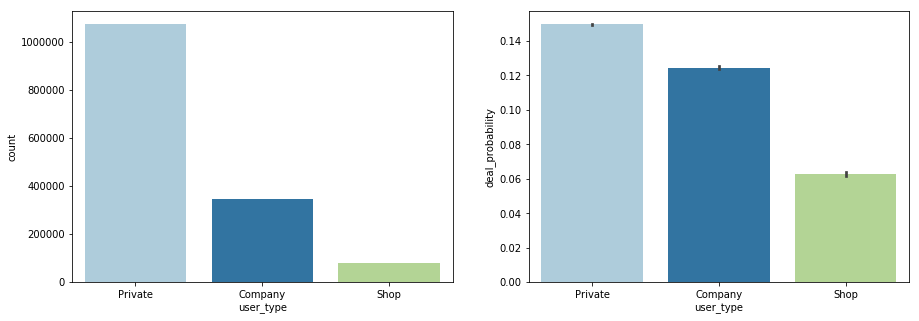

In [14]:
fig, axs = plt.subplots(ncols=2, sharey='col', figsize=(15,5))
sns.countplot(x="user_type", palette='Paired',data=data, ax=axs[0])
sns.barplot(x='user_type',  y='deal_probability', palette='Paired', data=data, ax=axs[1])
plt.show()


Obeserva-se nos gŕaficos abaixo, que a maioria das propagandas criadas durante esse período foram anúncios de produtos pessoais. Focando especificamente em roupas e acessórios, tanto para adultos quanto para crianças, obtemos, com as duas categorias juntas, quase 40% do número total de anúncios.

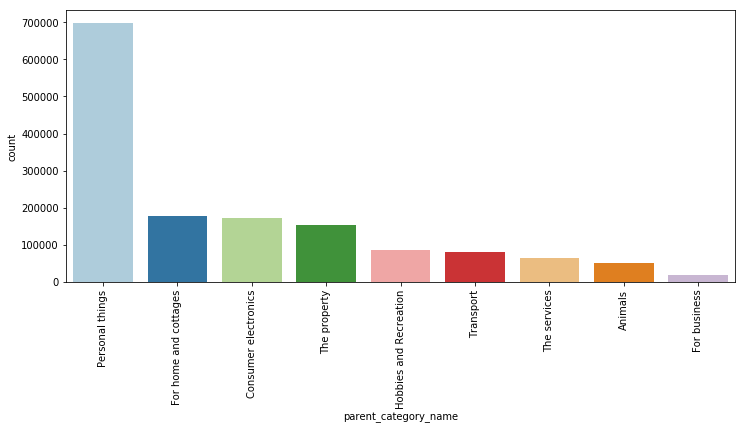

In [15]:
plt.figure(figsize=(12,5))
plt.xticks(rotation='vertical')
sns.countplot(x='parent_category_name', data=data, order = data["parent_category_name"].value_counts().index, palette='Paired' )
plt.show()

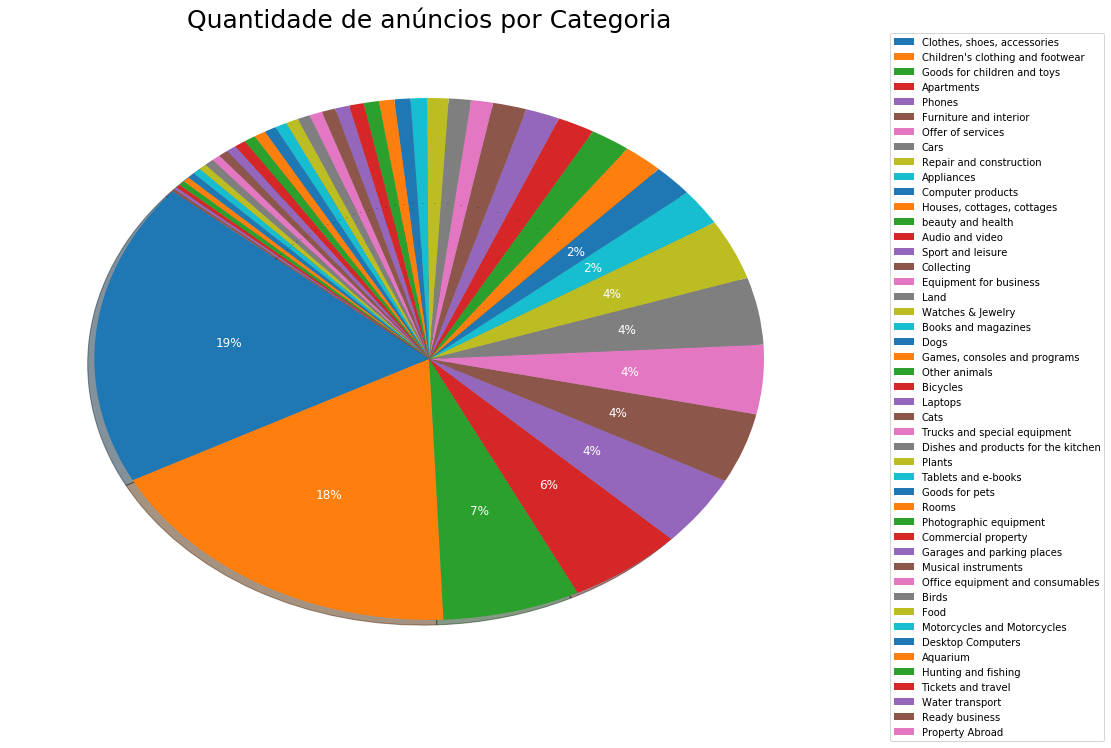

In [16]:
fig = plt.figure( figsize = (15,12))
ax = fig.add_subplot( 1, 1, 1 )
patches, texts,autotexts = plt.pie(data["category_name"].value_counts().values,
        shadow=True, startangle=140, autopct='%.0f%%')
plt.legend(patches, data["category_name"].value_counts().index, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i in range(0, len(data["category_name"].value_counts())):
    if(i<=10):
        autotexts[i].set_size('large')
        autotexts[i].set_color('w')
    else:
        autotexts[i].set_size(0)
plt.title('Quantidade de anúncios por Categoria', fontsize= 25)
plt.show()


Entretanto, não são os anúncios de produtos pessoais que possuem maior probabilidade de sucesso, e sim os de serviços seguidos de anúncios de transporte e animais.

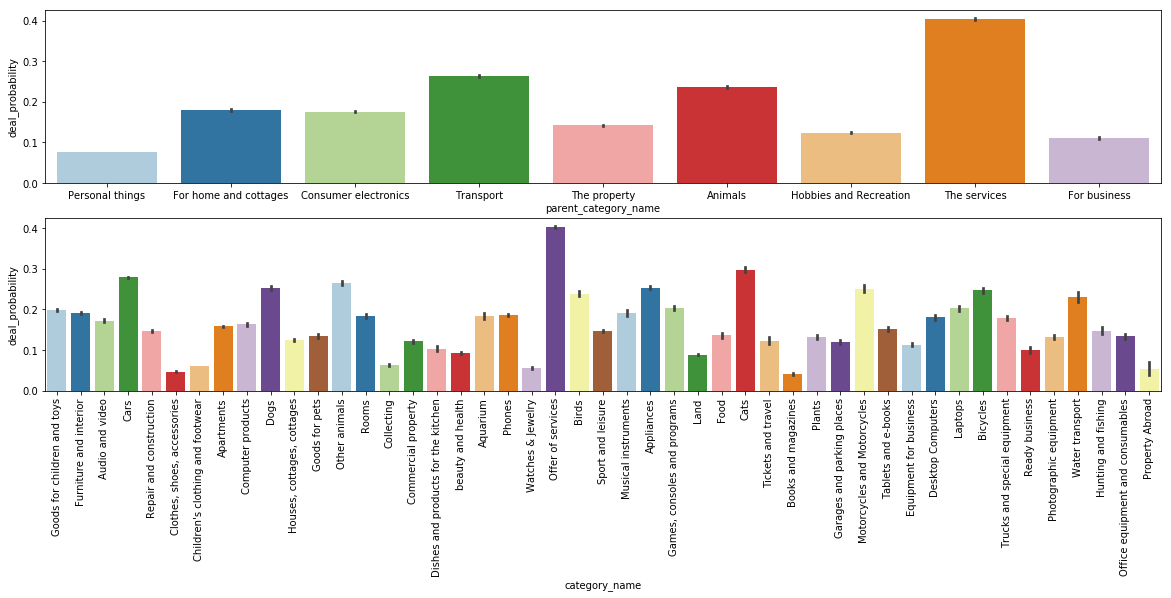

In [17]:
fig, axs = plt.subplots(nrows=2, figsize=(20,7))
sns.barplot(x='parent_category_name',  y='deal_probability', palette='Paired', data=data, ax=axs[0])
sns.barplot(x='category_name',  y='deal_probability', palette='Paired', data=data, ax=axs[1])
plt.xticks(rotation='vertical')
plt.show()


### Média da Probabilidade de Venda para outras variaveis categóricas

In [18]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

param_1 = data.groupby('param_1').mean().sort_values('deal_probability', ascending=False).head(15).drop(['price','image_top_1'], axis=1)
param_2 = data.groupby('param_2').mean().sort_values('deal_probability', ascending=False).head(15).drop(['price','image_top_1'], axis=1)
param_3 = data.groupby('param_3').mean().sort_values('deal_probability', ascending=False).head(15).drop(['price','image_top_1'], axis=1)

display_side_by_side(param_1,param_2,param_3)


,deal_probability
param_1,
Briar,0.67
Repair and maintenance of machinery,0.57
The Urals Rex,0.55
"Transport, transportation",0.54
"Garden, accomplishment",0.53
Belgian Griffon,0.47
"Nurses, nurse",0.46
Cleaning,0.44
Master for an hour,0.44


In [19]:
region = data.groupby('region').mean().sort_values('deal_probability', ascending=False).head(20).drop(['price','image_top_1'], axis=1)
city = data.groupby('city').mean().sort_values('deal_probability', ascending=False).head(20).drop(['price','image_top_1'], axis=1)
display_side_by_side(region,city)


,deal_probability
region,
Orenburg region,0.16
Stavropol region,0.15
Bashkortostan,0.15
Udmurtia,0.15
Krasnodar region,0.15
Nizhny Novgorod Region,0.15
Saratov region,0.15
Volgograd region,0.15
Belgorod region,0.15


### Probabilidade de Venda em relação a quantidade de caracteres e da presença de imagem

In [20]:
data['title length'] = data['title'].str.len()
data['description length'] = data['description'].str.len()

data.head(5)

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,activation_date,user_type,image,image_top_1,deal_probability,title length,description length
0,e00f8ff2eaf9,Sverdlovsk region,Ekaterinburg,Personal things,Goods for children and toys,Bed dress,nan,nan,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.00,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.00,0.13,21,58.00
1,39aeb48f0017,Samara Region,Samara,For home and cottages,Furniture and interior,Other,nan,nan,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.00,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.00,0.00,17,41.00
2,91e2f88dd6e3,Rostov region,Rostov-na-Donu,Consumer electronics,Audio and video,"Video, DVD and Blu-ray players",nan,nan,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.00,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.00,0.43,14,99.00
3,bf5cccea572d,Tatarstan,Naberezhnye Chelny,Personal things,Goods for children and toys,Car seats,nan,nan,Автокресло,Продам кресло от0-25кг,2200.00,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.00,0.80,10,22.00
4,ef50846afc0b,Volgograd region,Volgograd,Transport,Cars,With mileage,VAZ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.00,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.00,0.21,14,24.00
